# 2D Histogrammer

In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [9]:
# Find alle Excel-filer i en mappe
filer = glob.glob("/Users/mathias/Desktop/Uni/4. Semester/Dataprojekt/Rådata/2023 AAR vaskeri data/PLC*.xlsx")

# Indlæs alle filer og saml dem i en liste
dataframes = [pd.read_excel(fil, skiprows=2) for fil in filer]

#Eventuelt kombiner alle til én DataFrame
samlet_df = pd.concat(dataframes, ignore_index=True)

def kategoriser_produkt(produktnavn):
    produktnavn = str(produktnavn).lower()
    
    #Tjek i prioriteret rækkefølge (mest specifik først)
    if any(ord in produktnavn for ord in ['forklæde', 'forkl']):
        return 'Forklæde'
    elif 'shorts' in produktnavn:
        return 'Shorts'
    elif any(ord in produktnavn for ord in ['sweat', 'fleece', 'ziptrøje']):
        return 'Sweatshirt'
    elif any(ord in produktnavn for ord in ['t-shirt', 'polo', 'tshirt']):
        return 'T-shirt'
    elif 'kittel' in produktnavn or re.search(r'\bkit[\s\.]', produktnavn):
        return 'Kittel'
    elif any(ord in produktnavn for ord in ['skjorte', 'skj.']):
        return 'Skjorte'
    elif any(ord in produktnavn for ord in ['jakke', 'vest', 'jak', 'jk']):
        return 'Jakke'
    elif any(ord in produktnavn for ord in ['buks', 'benk', 'benklæder', 'unisexben', 'jeans']):
        return 'Bukser'
    elif 'sok' in produktnavn or 'strømpe' in produktnavn:
        return 'Sokker'
    elif 'overall' in produktnavn or 'kedeldr' in produktnavn or 'heldragt' in produktnavn:
        return 'Overall'
    elif any(ord in produktnavn for ord in ['kokkebuss', 'busseron', 'halvbusseron']):
        return 'Busseron'
    else:
        return 'Andet'

 #Tilføj kategori
samlet_df['Kategori'] = samlet_df['Produkt - Produkt'].apply(kategoriser_produkt)

 #Nu kan du filtrere uden overlap
skjorte_data = samlet_df[samlet_df['Kategori'] == 'Skjorte']
shorts_data = samlet_df[samlet_df['Kategori'] == 'Shorts']
buks_data = samlet_df[samlet_df['Kategori'] == 'Bukser']
tshirt_data = samlet_df[samlet_df['Kategori'] == 'T-shirt']
sweatshirt_data = samlet_df[samlet_df['Kategori'] == 'Sweatshirt']
jakke_data = samlet_df[samlet_df['Kategori'] == 'Jakke']
forklæde_data = samlet_df[samlet_df['Kategori'] == 'Forklæde']
sok_data = samlet_df[samlet_df['Kategori'] == 'Sokker']
kittel_data = samlet_df[samlet_df['Kategori'] == 'Kittel']
busseron_data = samlet_df[samlet_df['Kategori'] == 'Busseron']
andre_data = samlet_df[samlet_df['Kategori'] == 'Andet']

# Tjek resultater
print(samlet_df['Kategori'].value_counts())

Kategori
Bukser        77905
T-shirt       75396
Jakke         25501
Skjorte       18147
Sweatshirt    13675
Overall       11763
Andet         10088
Busseron       7255
Forklæde       3360
Kittel         2868
Shorts         2023
Sokker          730
Name: count, dtype: int64


Output()

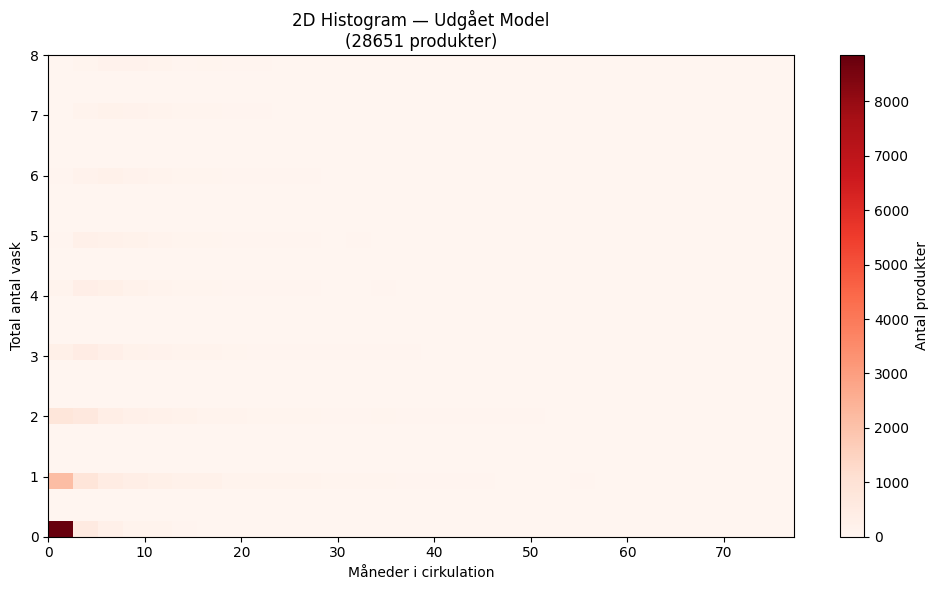

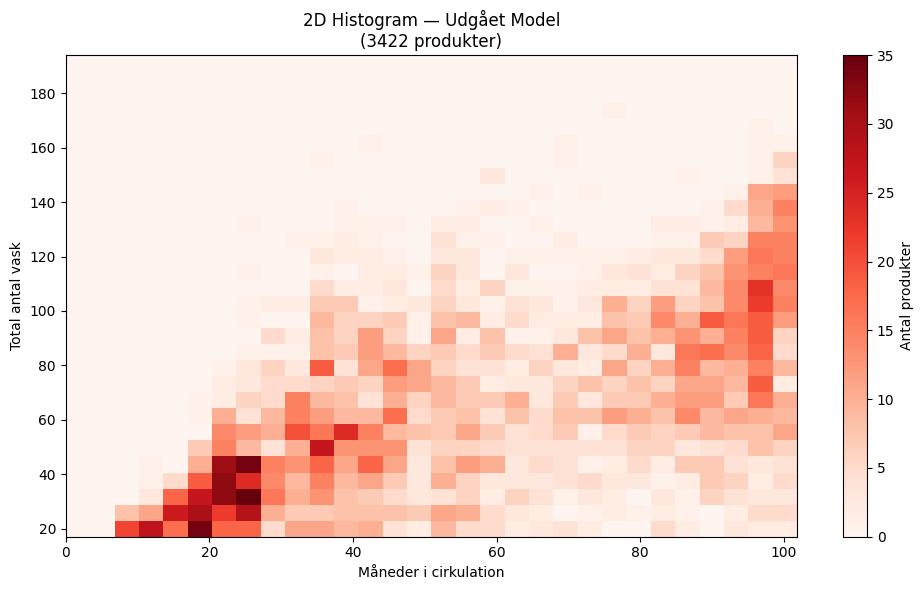

In [ ]:
import os
import json
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

SCALE_CONFIG = {
    'Dage':    {'divisor': 1,       'label': 'Dage i cirkulation'},
    'Måneder': {'divisor': 30.437,  'label': 'Måneder i cirkulation'},
    'År':      {'divisor': 365.25,  'label': 'År i cirkulation'},
}

DATASET_LABELS = {
    'Samlet':     'Samlet_df',
    'Skjorte':    'skjorte_data',
    'Shorts':     'shorts_data',
    'Bukser':     'buks_data',
    'T-shirt':    'tshirt_data',
    'Sweatshirt': 'sweatshirt_data',
    'Jakke':      'jakke_data',
    'Forklæde':   'forklæde_data',
    'Sokker':     'sok_data',
    'Kittel':     'kittel_data',
    'Busseron':   'busseron_data',
}

# Folder where plots and settings are saved (created automatically)
SAVE_DIR = 'histogram_gemte'


def twod_histogram(data, kassationssårsag, bins, min_dage, max_dage, min_vask, max_vask,
                   x_skala, save_path=None):
    kassation_data = data[data['Kassationsårsag (ui)'] == kassationssårsag]
    kassation_data = kassation_data[
        (kassation_data['Dage i cirkulation'] >= min_dage) &
        (kassation_data['Dage i cirkulation'] <= max_dage) &
        (kassation_data['Total antal vask'] >= min_vask) &
        (kassation_data['Total antal vask'] <= max_vask)
    ]

    divisor = SCALE_CONFIG[x_skala]['divisor']
    x_label = SCALE_CONFIG[x_skala]['label']
    x_values = kassation_data['Dage i cirkulation'] / divisor
    x_min    = min_dage / divisor
    x_max    = max_dage / divisor

    fig, ax = plt.subplots(figsize=(10, 6))

    if len(kassation_data) == 0:
        ax.text(0.5, 0.5, 'Ingen data i det valgte interval',
                ha='center', va='center', transform=ax.transAxes, fontsize=14, color='gray')
    else:
        h = ax.hist2d(
            x_values,
            kassation_data['Total antal vask'],
            bins=bins,
            cmap='Reds',
            range=[[x_min, x_max], [min_vask, max_vask]]
        )
        fig.colorbar(h[3], ax=ax, label='Antal produkter')

    ax.set_xlabel(x_label)
    ax.set_ylabel('Total antal vask')
    ax.set_title(f'2D Histogram — {kassationssårsag}\n({len(kassation_data)} produkter)')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(min_vask, max_vask)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def interactive_histogram(Samlet_df=None, skjorte_data=None, shorts_data=None, buks_data=None,
                           tshirt_data=None, sweatshirt_data=None, jakke_data=None,
                           forklæde_data=None, sok_data=None, kittel_data=None, busseron_data=None):

    all_dfs = {
        'Samlet_df':       Samlet_df,
        'skjorte_data':    skjorte_data,
        'shorts_data':     shorts_data,
        'buks_data':       buks_data,
        'tshirt_data':     tshirt_data,
        'sweatshirt_data': sweatshirt_data,
        'jakke_data':      jakke_data,
        'forklæde_data':   forklæde_data,
        'sok_data':        sok_data,
        'kittel_data':     kittel_data,
        'busseron_data':   busseron_data,
    }
    available = {label: all_dfs[varname]
                 for label, varname in DATASET_LABELS.items()
                 if all_dfs[varname] is not None}

    if not available:
        print("Ingen datasæt fundet — kald interactive_histogram() med dine DataFrames.")
        return

    # ── Widgets ────────────────────────────────────────────────────────────────

    dataset_widget = widgets.Dropdown(
        options=list(available.keys()),
        value=list(available.keys())[0],
        description='Datasæt:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='400px')
    )

    def get_arsager(label):
        return sorted(available[label]['Kassationsårsag (ui)'].dropna().unique().tolist())

    arsag_widget = widgets.Dropdown(
        options=get_arsager(dataset_widget.value),
        description='Årsag:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='400px')
    )

    skala_widget = widgets.ToggleButtons(
        options=['Dage', 'Måneder', 'År'],
        value='Dage',
        description='X-akse skala:',
        style={'description_width': '100px', 'button_width': '80px'},
    )

    bins_widget = widgets.IntSlider(
        value=30, min=5, max=80, step=1,
        description='Bins:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='500px')
    )

    def dage_max(label):
        return int(available[label]['Dage i cirkulation'].max()) + 100

    def vask_max(label):
        return int(available[label]['Total antal vask'].max()) + 10

    min_dage_widget = widgets.IntSlider(
        value=0, min=0, max=dage_max(dataset_widget.value), step=50,
        description='Min dage:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='500px')
    )
    max_dage_widget = widgets.IntSlider(
        value=dage_max(dataset_widget.value), min=0, max=dage_max(dataset_widget.value), step=50,
        description='Max dage:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='500px')
    )
    min_vask_widget = widgets.IntSlider(
        value=0, min=0, max=vask_max(dataset_widget.value), step=1,
        description='Min vask:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='500px')
    )
    max_vask_widget = widgets.IntSlider(
        value=vask_max(dataset_widget.value), min=0, max=vask_max(dataset_widget.value), step=1,
        description='Max vask:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='500px')
    )

    # ── Save button & status label ─────────────────────────────────────────────

    save_button = widgets.Button(
        description='💾  Gem graf + indstillinger',
        button_style='success',
        layout=widgets.Layout(width='260px', height='36px')
    )
    status_label = widgets.HTML(value='')

    def on_save(_):
        os.makedirs(SAVE_DIR, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        base_name = f"{dataset_widget.value}_{arsag_widget.value}_{timestamp}".replace(' ', '_')

        # Save PNG
        png_path = os.path.join(SAVE_DIR, base_name + '.png')
        twod_histogram(
            data=available[dataset_widget.value],
            kassationssårsag=arsag_widget.value,
            bins=bins_widget.value,
            min_dage=min_dage_widget.value,
            max_dage=max_dage_widget.value,
            min_vask=min_vask_widget.value,
            max_vask=max_vask_widget.value,
            x_skala=skala_widget.value,
            save_path=png_path,
        )

        # Save settings as JSON
        settings = {
            'datasæt':          dataset_widget.value,
            'kassationsårsag':  arsag_widget.value,
            'bins':             bins_widget.value,
            'min_dage':         min_dage_widget.value,
            'max_dage':         max_dage_widget.value,
            'min_vask':         min_vask_widget.value,
            'max_vask':         max_vask_widget.value,
            'x_skala':          skala_widget.value,
            'gemt':             datetime.now().isoformat(),
        }
        json_path = os.path.join(SAVE_DIR, base_name + '.json')
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(settings, f, ensure_ascii=False, indent=2)

        status_label.value = (
            f"<span style='color:green'>✔ Gemt: <code>{SAVE_DIR}/{base_name}.png</code> "
            f"og <code>.json</code></span>"
        )

    save_button.on_click(on_save)

    # ── Update sliders & årsager when dataset changes ─────────────────────────

    def on_dataset_change(change):
        label = change['new']
        df = available[label]

        new_dage_max = int(df['Dage i cirkulation'].max()) + 100
        new_vask_max = int(df['Total antal vask'].max()) + 10

        min_dage_widget.max = new_dage_max
        max_dage_widget.max = new_dage_max
        max_dage_widget.value = new_dage_max
        min_dage_widget.value = 0

        min_vask_widget.max = new_vask_max
        max_vask_widget.max = new_vask_max
        max_vask_widget.value = new_vask_max
        min_vask_widget.value = 0

        arsag_widget.options = get_arsager(label)
        status_label.value = ''

    dataset_widget.observe(on_dataset_change, names='value')

    # ── Wrapper ───────────────────────────────────────────────────────────────

    def plot_wrapper(dataset, kassationssårsag, bins, min_dage, max_dage, min_vask, max_vask, x_skala):
        twod_histogram(
            data=available[dataset],
            kassationssårsag=kassationssårsag,
            bins=bins,
            min_dage=min_dage,
            max_dage=max_dage,
            min_vask=min_vask,
            max_vask=max_vask,
            x_skala=x_skala,
        )

    # ── Layout ────────────────────────────────────────────────────────────────

    ui = widgets.VBox([
        widgets.HTML("<h3 style='margin-bottom:8px'>2D Histogram — Parametre</h3>"),
        widgets.HTML("<b>Datasæt</b>"),
        dataset_widget,
        widgets.HTML("<hr style='margin:8px 0'>"),
        widgets.HTML("<b>Kassationsårsag</b>"),
        arsag_widget,
        widgets.HTML("<hr style='margin:8px 0'>"),
        bins_widget,
        widgets.HTML("<hr style='margin:8px 0'>"),
        widgets.HTML("<b>X-akse visning (filtrering sker altid i dage)</b>"),
        skala_widget,
        widgets.HTML("<hr style='margin:8px 0'>"),
        widgets.HTML("<b>Dage i cirkulation</b>"),
        min_dage_widget,
        max_dage_widget,
        widgets.HTML("<hr style='margin:8px 0'>"),
        widgets.HTML("<b>Total antal vask</b>"),
        min_vask_widget,
        max_vask_widget,
        widgets.HTML("<hr style='margin:8px 0'>"),
        save_button,
        status_label,
    ])

    out = widgets.interactive_output(
        plot_wrapper,
        {
            'dataset':          dataset_widget,
            'kassationssårsag': arsag_widget,
            'bins':             bins_widget,
            'min_dage':         min_dage_widget,
            'max_dage':         max_dage_widget,
            'min_vask':         min_vask_widget,
            'max_vask':         max_vask_widget,
            'x_skala':          skala_widget,
        }
    )

    display(ui, out)


# ── Usage ──────────────────────────────────────────────────────────────────────
# Pass whichever DataFrames you have — unused ones can simply be left out:
#
interactive_histogram(
       Samlet_df=samlet_df,
       tshirt_data=tshirt_data,
       skjorte_data=skjorte_data,
       shorts_data=shorts_data,
       buks_data=buks_data,
       sweatshirt_data=sweatshirt_data,
       jakke_data=jakke_data,
       forklæde_data=forklæde_data,
       sok_data=sok_data,
       kittel_data=kittel_data,
       busseron_data=busseron_data,
   )
#
# Saved files appear in a folder called 'histogram_gemte' next to your notebook.
# Each save creates two files with a timestamp:
#   - DataSæt_Årsag_YYYYMMDD_HHMMSS.png   ← the plot image
#   - DataSæt_Årsag_YYYYMMDD_HHMMSS.json  ← the settings used
# ──────────────────────────────────────────────────────────────────────────────